#Import library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import time
import matplotlib.pyplot as plt
import random
import string
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

#import dataset and split data

In [ ]:
examples, metadata   = tfds.load('ted_hrlr_translate/pt_to_en' , with_info=True, as_supervised= True)
train_examples, val_examples , test_examples = examples['train'], examples['validation'],examples['test']

In [ ]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

In [ ]:
#sub_train = train_examples.take(15000)

In [ ]:
#len(sub_train)

In [ ]:
'''sub_train = list(train_examples.as_numpy_iterator())
train = train_examples[:20000]
len(train)'''

'sub_train = list(train_examples.as_numpy_iterator())\ntrain = train_examples[:20000]\nlen(train)'

###Display some data

In [ ]:
for pt_examples, en_examples in train_examples.batch(1).take(10):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
mas e se estes fatores fossem ativos ?

but what if it were active ?
mas eles não tinham a curiosidade de me testar .

but they did n't test for curiosity .
e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .

and this conscious defiance is why i , as an agnostic , can still have faith .
`` `` '' podem usar tudo sobre a mesa no meu corpo . ''

you can use everything on the table on me .
`` eu escrevo muito acerca do `` '' teatro de segurança '' '' , que são produtos que fazem as pessoas sentirem-se seguras mas que , na realidade , não fazem nada . ''

`` i write a lot about `` '' security theater , '' '' which are products that make people feel secure , but do n't actually do anything . ''
colocaram-no bem no fundo duma mina de ferro no minnes

##Text tokenization

In [ ]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [ ]:
sample_string = 'and when you improve searchability , you actually take away the one advantage of print , which is serendipity'

tokenized_string = tokenizer_en.encode(sample_string)
print (f'Tokenized string is {tokenized_string}')

Tokenized string is [4, 59, 15, 1792, 6561, 3060, 7952, 1, 15, 103, 134, 378, 3, 47, 6122, 6, 5311, 1, 91, 13, 1849, 559, 1609, 894]


In [ ]:
for ts in tokenized_string:
  print (f'{ts} ----> {tokenizer_en.decode([ts])}')

4 ----> and 
59 ----> when 
15 ----> you 
1792 ----> improve 
6561 ----> search
3060 ----> abilit
7952 ----> y
1 ---->  , 
15 ----> you 
103 ----> actually 
134 ----> take 
378 ----> away 
3 ----> the 
47 ----> one 
6122 ----> advantage 
6 ----> of 
5311 ----> print
1 ---->  , 
91 ----> which 
13 ----> is 
1849 ----> ser
559 ----> end
1609 ----> ip
894 ----> ity


##Add a start and end token to the input and target.

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [ ]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

drop examples with a length of over 40 tokens.

In [ ]:
MAX_LENGTH = 80
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
pr_list = []
en_list = []
for i ,j in train_dataset:
  pr_list.append(i)
  en_list.append(j)

In [ ]:
pr_list

#Positional encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis] ,  np.arange(d_model)[np.newaxis, :]  ,   d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 70, 512)


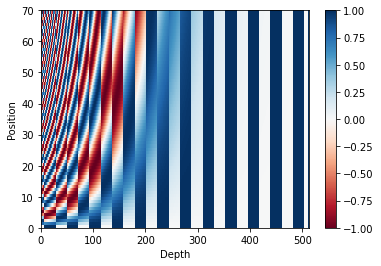

In [ ]:
pos_encoding = positional_encoding(70, 512)
print (pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#masking

In [ ]:
#change zero to one and other number to zero and attention when saw zero
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
#The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

#scaled dot product attention

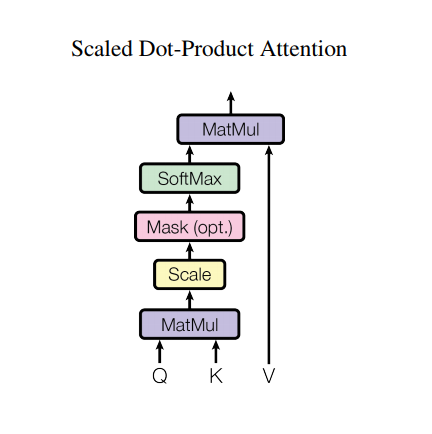

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.(optional)
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

#multi head attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

#Point wise feed forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

#Encoder layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

#Decoder layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

#Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

#Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

#Create the Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

#Set hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

#Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

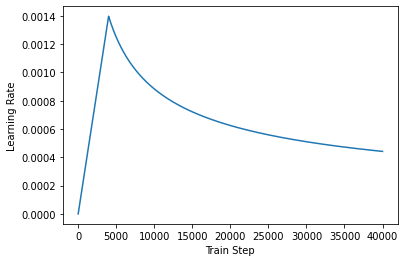

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#Loss and metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

#Training and checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "/content/drive/MyDrive/mamad"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 100

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

#Evaluate

In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

evaluate on test data

In [ ]:
for pt_examples, en_examples in test_examples.batch(1).take(50):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

depois , podem fazer-se e testar-se previsões .

then , predictions can be made and tested .
forçou a parar múltiplos laboratórios que ofereciam testes brca .

it had forced multiple labs that were offering brca testing to stop .
as formigas são um exemplo clássico ; as operárias trabalham para as rainhas e vice-versa .

ants are a classic example ; workers work for queens and queens work for workers .
uma em cada cem crianças no mundo nascem com uma doença cardíaca .

one of every hundred children born worldwide has some kind of heart disease .
neste momento da sua vida , ela está a sofrer de sida no seu expoente máximo e tinha pneumonia .

at this point in her life , she 's suffering with full-blown aids and had pneumonia .
onde estão as redes económicas ?

where are economic networks ?
( aplausos )

( applause )
eu usei os contentores de transporte , e também os alunos ajudaram-nos a fazer toda a mobília dos edifícios , para torná-los confortáveis​​ , dentro do orçamento do governo 

In [ ]:
translate("( risos ) parece-me que todos vocês são tocs , astrofísicos e ultramaratonistas .")
print ("Real translation:( laughter ) you 're all cfo , astrophysicists , ultra-marathoners , it turns out .")

Input: ( risos ) parece-me que todos vocês são tocs , astrofísicos e ultramaratonistas .
Predicted translation: ( laughter ) it seems to me all of you are interplanets , astrophysical and marbles .
Real translation:( laughter ) you 're all cfo , astrophysicists , ultra-marathoners , it turns out .


In [ ]:
translate("sabemos mais do que eles ?")
print ("Real translation:do we know better than them ?")

Input: sabemos mais do que eles ?
Predicted translation: do we know more than them ?
Real translation:do we know better than them ?


In [ ]:
translate("e isso afeta-nos a todos . ?")
print ("Real translation:and that affects all of us .")

Input: e isso afeta-nos a todos . ?
Predicted translation: and does that affect everyone . ?
Real translation:and that affects all of us .


In [ ]:
translate("eu não sou o meu pai .")
print ("Real translation:i am not my father .")

Input: eu não sou o meu pai .
Predicted translation: i 'm not my dad .
Real translation:i am not my father .


In [ ]:
translate("eles têm dinheiro e poder .", plot='decoder_layer4_block2')
print ("Real translation:they have money and power .")

In [ ]:
translate("neste vídeo , podemos ver como um cateter muito fino leva a bobina até ao coração .")
print ("Real translation:in this video , we can see how a very tiny catheter takes the coil to the heart .")

Input: neste vídeo , podemos ver como um cateter muito fino leva a bobina até ao coração .
Predicted translation: in this video , we can see how a catheter get too fine to bina by putting it up to the heart .
Real translation:in this video , we can see how a very tiny catheter takes the coil to the heart .


In [ ]:
translate("depois , podem fazer-se e testar-se previsões .")
print ("Real translation:then , predictions can be made and tested .")

Input: depois , podem fazer-se e testar-se previsões .
Predicted translation: then they can do it and test if possible .
Real translation:then , predictions can be made and tested .


In [ ]:
translate("forçou a parar múltiplos laboratórios que ofereciam testes brca .")
print ("Real translation:it had forced multiple labs that were offering brca testing to stop .")

Input: forçou a parar múltiplos laboratórios que ofereciam testes brca .
Predicted translation: it forced him to stop multiple laboratories that have offered bage tests .
Real translation:it had forced multiple labs that were offering brca testing to stop .


In [ ]:
translate("as formigas são um exemplo clássico ; as operárias trabalham para as rainhas e vice-versa .")
print ("Real translation:ants are a classic example ; workers work for queens and queens work for workers .")

Input: as formigas são um exemplo clássico ; as operárias trabalham para as rainhas e vice-versa .
Predicted translation: ig is a classic example ; opposed to quee and vice versal .
Real translation:ants are a classic example ; workers work for queens and queens work for workers .


In [ ]:
translate("uma em cada cem crianças no mundo nascem com uma doença cardíaca .")
print ("Real translation:one of every hundred children born worldwide has some kind of heart disease .")

Input: uma em cada cem crianças no mundo nascem com uma doença cardíaca .
Predicted translation: one in every 100 children in the world are born with an heart disease .
Real translation:one of every hundred children born worldwide has some kind of heart disease .


In [ ]:
translate("neste momento da sua vida , ela está a sofrer de sida no seu expoente máximo e tinha pneumonia .")
print ("Real translation:at this point in her life , she 's suffering with full-blown aids and had pneumonia .")

Input: neste momento da sua vida , ela está a sofrer de sida no seu expoente máximo e tinha pneumonia .
Predicted translation: at this moment of her life , she 's being suffered from aids in its exhibition and she had neural directon .
Real translation:at this point in her life , she 's suffering with full-blown aids and had pneumonia .


In [ ]:
translate("onde estão as redes económicas ?")
print ("Real translation:where are economic networks ?")

Input: onde estão as redes económicas ?
Predicted translation: where are the economic networks ?
Real translation:where are economic networks ?


In [ ]:
translate("a partir daquele momento , comecei a pensar .")
print ("Real translation: at that moment , i started thinking .")

Input: a partir daquele momento , comecei a pensar .
Predicted translation: from that moment i started thinking .
Real translation: at that moment , i started thinking .


In [ ]:
translate("a luz nunca desaparece .", plot='decoder_layer4_block2')
print ("Real translation: the light never goes out .")

In [ ]:
translate("é um museu muito popular agora , e criei um grande monumento para o governo .")
print ("Real translation: it 's a very popular museum now , and i created a big monument for the government .")

Input: é um museu muito popular agora , e criei um grande monumento para o governo .
Predicted translation: it 's a very popular museum now , and i created a big monument to government .
Real translation: it 's a very popular museum now , and i created a big monument for the government .


In [ ]:
translate("e , no entanto , a ironia é que a única maneira de podermos fazer qualquer coisa nova é dar um passo nessa direção .")
print ("Real translation: and yet , the irony is , the only way we can ever do anything new is to step into that space .")

Input: e , no entanto , a ironia é que a única maneira de podermos fazer qualquer coisa nova é dar um passo nessa direção .
Predicted translation: and yet , the irony is that the only way we can do anything new thing is to take that step in that direction .
Real translation: and yet , the irony is , the only way we can ever do anything new is to step into that space .


In [ ]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

In [ ]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors has heard about this idea of all .
Real translation: and my neighboring homes heard about this idea .


In [ ]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm very quickly to share with you some magic stories that have happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


In [ ]:
translate("este é um problema que temos que resolver.", plot='decoder_layer4_block2')
print ("Real translation: this is a problem we have to solve .")